In [1]:
import pandas as pd
import numpy as np
import sys , os 
import seaborn as sns 
import sklearn as sk
from sklearn.metrics import classification_report,matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style(style="whitegrid")

PDB_BM5 = [
'1EXB','1JTD','1M27','1RKE','2A1A','2GAF','2GTP','2VXT','2W9E',
'2X9A','2YVJ','3A4S','3AAA','BAAD','3AAD','3BIW','3BX7',
'3DAW','3EO1','3EOA','3F1P','3FN1','3G6D','3H11',
'3H2V','3HI6','3HMX','3K75','3L5W','3L89','3LVK','3MXW',
'BP57','CP57','3P57','3PC8','3R9A','3RVW','3S9D','3SZK',
'3V6Z','3VLB','4DN4','4FQI','4FZA','4G6J','4G6M','4GAM',
'4GXU','4H03','4HX3','4IZ7','4JCV','4LW4','4M76'
]

"""use the ML_env to reproduce the results reported"""

'use the ML_env to reproduce the results reported'

In [2]:
print (f"Numpy version:{np.__version__}")
print (f"Pandas version:{pd.__version__}")
print (f"Sklearn version:{sk.__version__}")

Numpy version:1.19.2
Pandas version:1.2.1
Sklearn version:0.23.2


In [3]:
def load_data_sets():
    all_balanced_data = pd.read_csv("../data/Clean_dataframe_balanced_all_data_ccharppi_4_march_2020_complete.csv",dtype={'class_q': 'object'})
    all_balanced_data.set_index('Conf',inplace=True)
    all_balanced_data.loc["Z_1JTG_1136_M.pdb","DDG_V"]  = all_balanced_data["DDG_V"].mean()
    print (all_balanced_data.shape)
    all_unbalanced_data = pd.read_csv("../data/Clean_dataframe_unbalanced_all_data_ccharppi_4_march_2020_complete.csv",dtype={'class_q': 'object'})
    all_unbalanced_data.set_index('Conf',inplace=True)
    all_unbalanced_data.loc["Z_1JTG_1136_M.pdb","DDG_V"]  = all_balanced_data["DDG_V"].mean()


#     Scorers_balanced_data = pd.read_csv("../data/Clean_dataframe_balanced_scorers_set_feb_12_2021.csv")
    Scorers_balanced_data = pd.read_csv("../data/Clean_dataframe_balanced_scorers_set.csv")
    print (Scorers_balanced_data.shape)


    Scorers_balanced_data.set_index('Conf',inplace=True)
    Scorers_balanced_data.dropna(inplace=True)

#     Scorers_unbalanced_data = pd.read_csv("../data/Clean_dataframe_unbalanced_scorers_set_feb_12_2021.csv")
    Scorers_unbalanced_data = pd.read_csv("../data/Clean_dataframe_unbalanced_scorers_set.csv")

    Scorers_unbalanced_data.set_index('Conf',inplace=True)
    Scorers_unbalanced_data.dropna(inplace=True)

    X_train = all_balanced_data[~all_balanced_data["idx"].isin(PDB_BM5) ]
    y_train = all_balanced_data[~all_balanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')

            ## data set for less than 5 
    X_val = all_balanced_data[all_balanced_data["idx"].isin(PDB_BM5) ]
    y_val = all_balanced_data[all_balanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')
    #         print (X_test.size,y_test.size)
            ## data set for less than 5 
    X_val_u = all_unbalanced_data[all_unbalanced_data["idx"].isin(PDB_BM5) ]
    y_val_u = all_unbalanced_data[all_unbalanced_data["idx"].isin(PDB_BM5) ]["label_binary"].astype('bool')
    
    X_test = Scorers_balanced_data
    y_test = Scorers_balanced_data["binary_label"].astype('bool')
    
    X_test_u = Scorers_unbalanced_data
    y_test_u = Scorers_unbalanced_data["binary_label"].astype('bool')
    
    X_test_u.rename(columns={'NIS Polar' :'Nis_Polar',
                                  'Nis Apolar':'Nis_Apolar',
                                  'BSA Apolar':'BSA_Apolar',
                                  'BSA Polar' :'BSA_Polar',
                                'binary_label':'label_binary'
                            },inplace=True)
    X_test.rename(columns={'NIS Polar' :'Nis_Polar',
                                  'Nis Apolar':'Nis_Apolar',
                                  'BSA Apolar':'BSA_Apolar',
                                  'BSA Polar' :'BSA_Polar',
                                   'binary_label':'label_binary'
                          },inplace=True)
    
#     for x in X_val_u.columns:
#         if x not in X_test.columns:
#             print (x)
    return X_train, y_train , X_val, y_val, X_test, y_test ,X_val_u, y_val_u, X_test_u, y_test_u 

In [4]:
X_train, y_train , X_val, y_val, X_test, y_test ,X_val_u, y_val_u, X_test_u, y_test_u  = load_data_sets()

(73684, 161)
(3990, 162)


In [5]:
def scaling_data_selected(X_train,X_test,X_test_unbalanced):
    scaler = StandardScaler()


    selected_feat = ['CONSRANK_val','AP_GOAP_DF','CP_TD','CP_D1','CP_HLPL',
                      'DDG_V','CP_MJ3h','PYDOCK_TOT','ELE','CP_SKOIP',
                      'SIPPER','AP_DFIRE2','AP_dDFIRE','AP_PISA','CP_RMFCA',
                     ]
    
    X_train = X_train[selected_feat]
    X_test = X_test[selected_feat]
    X_test_unbalanced= X_test_unbalanced[selected_feat]


    scaler.fit(X_train)
    scaled_train = scaler.transform(X_train)
    scaled_test = scaler.transform(X_test)
    scaled_test_u = scaler.transform(X_test_unbalanced)
    return scaled_train,scaled_test,scaled_test_u

In [6]:
def scaling_data(X_train,X_test,X_test_unbalanced):
    features = ['idx','class_q','pdb1','chains_pdb1','pdb2','chains_pdb2',
                'label_binary','DQ_val','binary_label','identification','labels']
    scaler = StandardScaler()

    for x in features :
        if x in X_train.columns:
            X_train= X_train.drop(x,axis=1)            
    for x in features :
        if x in X_test.columns: 
                X_test = X_test.drop(x,axis=1)
            
    for x in features :
        if x in X_test_unbalanced.columns:
            X_test_unbalanced= X_test_unbalanced.drop(x,axis=1)

    scaler.fit(X_train)
    scaled_train = scaler.transform(X_train)
    scaled_test = scaler.transform(X_test)
    scaled_test_u = scaler.transform(X_test_unbalanced)
    return scaled_train,scaled_test,scaled_test_u

In [7]:
"""funtions to manage the tags and classes"""
def add_quality_class_binary (z):
    if "_I.pdb" in z or "_G.pdb" in z:
        return 0.0
    else:
        return 1.0
def get_the_tag_case(x):
    tag = x.split("_")[1]
    return tag
    
def get_the_tag_number(x):
    tag = x.split("_")[2]
    return int(tag)

In [8]:
def load_the_big_files():
    """This funtions will load the 10Kfiles , 
    this files need the label columns that can 
    be derived from the Conf column"""
    
    all_info = [] 
    for idx in PDB_BM5:
        dataframe = pd.read_csv(f"../data/3K_results_ZDock/{idx}_Zdock_ccharppi_3K.csv")
        dataframe["label_binary"] = dataframe["Conf"].apply(add_quality_class_binary)
        dataframe["idx"] = idx
        dataframe["Number"] = dataframe["Conf"].apply(get_the_tag_number)
        dataframe  = dataframe.sort_values(by="Number",ascending=True)
        dataframe.set_index('Conf',inplace=True)
        all_info.append (dataframe) 
    
    final_df_zdock = pd.concat(all_info)
    
    
    
    all_info = [] 
    for idx in PDB_BM5:
#         print (idx)
        dataframe = pd.read_csv(f"../data/3K_results_PyDock/{idx}_ftdock_ccharppi_3K.csv")
        dataframe["label_binary"] = dataframe["Conf"].apply(add_quality_class_binary)
        dataframe["idx"] = idx
        dataframe["Number"] = dataframe["Conf"].apply(get_the_tag_number)
        dataframe  = dataframe.sort_values(by="Number",ascending=True)
        dataframe.set_index('Conf',inplace=True)
        all_info.append (dataframe) 
    
    final_df_pydock = pd.concat(all_info)
    return final_df_zdock, final_df_pydock

In [9]:
tenk_load_zdock, tenk_load_pydock = load_the_big_files()

In [10]:
# tenk_load.info()

In [11]:
tenk_load_zdock.shape 

tenk_load_pydock.shape
# test = pd.read_csv("../data/ZDOCK_10K_results/1EXB_Zdock_ccharppi_10K.csv")

(165014, 82)

In [12]:
# test["label_binary"] = test["Conf"].apply(add_quality_class_binary)
# test["idx"] = "1EXB"
# test["Number"] = test["Conf"].apply(get_the_tag_number)
# test  = test.sort_values(by="Number",ascending=True)
# test.set_index('Conf',inplace=True)

In [13]:
# test.head()

In [14]:
# rfc_all_feat = RandomForestClassifier(n_jobs=-1,
#                                          n_estimators=100,
#                                          random_state=32,
#                                          min_samples_split= 10 , 
#                                          class_weight={0:1.2,1:0.1})
rfc_sel_feat = RandomForestClassifier(n_jobs=-1,
                                         n_estimators=100,
                                         random_state=32,
                                         min_samples_split= 10 , 
                                         class_weight={0:1.2,1:0.1})

In [15]:
# X_train_w, X_test_w, X_test_u_w = scaling_data(X_train, X_test, X_test_u)
# X_train_w, X_val_w, X_val_u_w = scaling_data(X_train, X_val, X_val_u)

X_train_fs, X_test_fs, X_test_u_fs = scaling_data_selected(X_train, X_test, X_test_u)
# X_train_fs, X_val_fs, X_val_u_fs = scaling_data_selected(X_train, X_val, X_val_u)

### Here instead of the normal Valiadtion mixed each of the methods have its X_val_u_fs
X_train_fs, X_val_fs, X_val_u_fs_zd = scaling_data_selected(X_train, X_val, tenk_load_zdock)
X_train_fs, X_val_fs, X_val_u_fs_py = scaling_data_selected(X_train, X_val, tenk_load_pydock)

In [16]:
np.random.seed(seed = 101) 

rfc_sel_feat.fit(X_train_fs,y_train)

RandomForestClassifier(class_weight={0: 1.2, 1: 0.1}, min_samples_split=10,
                       n_jobs=-1, random_state=32)

In [17]:
# rfc_all_feat.fit(X_train_w,y_train)

In [18]:
def save_metrics_results(model,x_test,y_test,tag):
    # target_names = ['Incorrect', 'Correct']

    y_pred = model.predict(x_test)
    cr = classification_report(y_true=y_test, y_pred=y_pred,output_dict=True)
    mmc = matthews_corrcoef(y_true=y_test, y_pred=y_pred)
    # print (cr)
    acc = cr["accuracy"]
    rec_false = cr["False"]["recall"]
    rec_true  = cr["True"]["recall"]
    pres_false = cr["False"]["precision"]
    pres_true = cr["True"]["precision"]
    f1_false =  cr["False"]["f1-score"]
    f1_true =  cr["True"]["f1-score"]

    results = {
        "Accuracy": acc,
        "Recall_inc":rec_false,
        "Recall_cor":rec_true,
        "Precision_inc":pres_false ,
        "Precision_cor":pres_true,
        "F1_inc":f1_false,
        "F1_cor":f1_true,
        "MCC":mmc
    }
    mean_df = pd.DataFrame(data=results,index=[f"{tag}"])
    return mean_df


In [22]:
y_pred= rfc_sel_feat.predict(X_test_u_fs)

In [23]:
print (classification_report( y_true=y_test_u ,y_pred= y_pred))

              precision    recall  f1-score   support

       False       1.00      0.67      0.80     16618
        True       0.28      0.99      0.44      2160

    accuracy                           0.71     18778
   macro avg       0.64      0.83      0.62     18778
weighted avg       0.91      0.71      0.76     18778



In [24]:
y_val_u = tenk_load_zdock["label_binary"].astype('bool')

In [25]:
y_pred= rfc_sel_feat.predict(X_val_u_fs_zd)

In [26]:
print (classification_report( y_true=y_val_u,y_pred= y_pred))

              precision    recall  f1-score   support

       False       1.00      0.39      0.56    150476
        True       0.04      0.97      0.08      3958

    accuracy                           0.40    154434
   macro avg       0.52      0.68      0.32    154434
weighted avg       0.97      0.40      0.55    154434



In [27]:
validation = save_metrics_results(model=rfc_sel_feat,
                                  x_test=X_val_u_fs_zd,
                                  y_test=y_val_u,
                                  tag="BM5 update Zdock")


In [28]:
print ( validation.T.to_latex() ) 

\begin{tabular}{lr}
\toprule
{} &  BM5 update \\
\midrule
Accuracy      &    0.401829 \\
Recall\_inc    &    0.386759 \\
Recall\_cor    &    0.974735 \\
Precision\_inc &    0.998285 \\
Precision\_cor &    0.040131 \\
F1\_inc        &    0.557522 \\
F1\_cor        &    0.077088 \\
MCC           &    0.117843 \\
\bottomrule
\end{tabular}



In [29]:
y_val_u = tenk_load_pydock["label_binary"].astype('bool')

In [30]:
y_pred= rfc_sel_feat.predict(X_val_u_fs_py)

In [31]:
print (classification_report( y_true=y_val_u,y_pred= y_pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00    164765
        True       0.03      0.02      0.02       249

    accuracy                           1.00    165014
   macro avg       0.51      0.51      0.51    165014
weighted avg       1.00      1.00      1.00    165014



In [32]:
validation = save_metrics_results(model=rfc_sel_feat,
                                  x_test=X_val_u_fs_py,
                                  y_test=y_val_u,
                                  tag="BM5 update Pydock")

In [33]:
print ( validation.T.to_latex() ) 

\begin{tabular}{lr}
\toprule
{} &  BM5 update \\
\midrule
Accuracy      &    0.997673 \\
Recall\_inc    &    0.999156 \\
Recall\_cor    &    0.016064 \\
Precision\_inc &    0.998514 \\
Precision\_cor &    0.027972 \\
F1\_inc        &    0.998835 \\
F1\_cor        &    0.020408 \\
MCC           &    0.020078 \\
\bottomrule
\end{tabular}



In [34]:
test = save_metrics_results(model=rfc_sel_feat,
                            x_test=X_test_u_fs,
                            y_test=y_test_u,
                            tag="Scorers")

print ( test.T.to_latex() ) 

\begin{tabular}{lr}
\toprule
{} &   Scorers \\
\midrule
Accuracy      &  0.707317 \\
Recall\_inc    &  0.671200 \\
Recall\_cor    &  0.985185 \\
Precision\_inc &  0.997139 \\
Precision\_cor &  0.280295 \\
F1\_inc        &  0.802331 \\
F1\_cor        &  0.436423 \\
MCC           &  0.426736 \\
\bottomrule
\end{tabular}



In [35]:
def get_success_rate(df,sel):
    """this funtion read a pandas dataframe and that dataframe need the columns
    idx , proba_true , and the label_binary"""
    total_size = {"val":float(len(PDB_BM5)),"test":float(13)}
    
    tops = [1,10,100,1000]
    tcount = [0 for y in range(len(tops))]
    names = [ [] for y in range(len(tops))]
    ranks = []
    for m in df['idx'].unique():
#         print (m, end=" ")
        found = False
        count = 0
        selection = df[df["idx"]==m]
        selection= selection.sort_values(by=["proba_true"], ascending=False)
#         print (selection)
        for x in selection["label_binary"].values:
            count +=1
            if x != False:
#                 print (x,count)
                if not found:
                    rank = count
                    ranks.append(count)
                found = True
        if found:

            for z in range(len(tops)):
                if  rank < tops[z]+1:
                    tcount[z] += 1
                    if m not in names:
                        names[z].append(m)

    print (tcount)
    for y in tcount:
#         print ( float(y) )
    #     print (y)
        print ( round(float(y)/total_size[sel],4)*100 , end=" ")
    print ()
    for m in names:
        print (m)

In [36]:
def convert_pred(model , X_test_val, X_ori ):
    df_pred = pd.DataFrame( model.predict_proba(X_test_val) , 
                                columns=["proba_false","proba_true"])
    df_pred = df_pred.set_index( X_ori.index ) 
    label = X_ori["label_binary"].astype('bool')
    df_pred = pd.concat( [ X_ori["idx"],label, df_pred ], axis=1)
#     df_pred = df_pred["label_binary"].astype('bool')
    
    return df_pred

In [37]:
df_pred = convert_pred ( rfc_sel_feat, X_test_u_fs, X_test_u  )

In [38]:
get_success_rate(df_pred,"test")


[6, 9, 10, 13]
46.150000000000006 69.23 76.92 100.0 
['Target29', 'Target37', 'Target40', 'Target41', 'Target47', 'Target50']
['Target29', 'Target32', 'Target37', 'Target40', 'Target41', 'Target46', 'Target47', 'Target50', 'Target53']
['Target29', 'Target32', 'Target37', 'Target39', 'Target40', 'Target41', 'Target46', 'Target47', 'Target50', 'Target53']
['Target29', 'Target30', 'Target32', 'Target35', 'Target37', 'Target39', 'Target40', 'Target41', 'Target46', 'Target47', 'Target50', 'Target53', 'Target54']


In [39]:
df_pred = convert_pred ( rfc_sel_feat, X_val_u_fs_py, tenk_load_pydock  )

In [40]:
get_success_rate(df_pred,"val")


[4, 11, 23, 37]
7.2700000000000005 20.0 41.82 67.27 
['1JTD', '3F1P', '3H11', '4G6M']
['1JTD', '3DAW', '3F1P', '3H11', '3K75', '3LVK', '3PC8', '3S9D', '4DN4', '4G6M', '4H03']
['1JTD', '1M27', '1RKE', '2A1A', '2VXT', '2W9E', '2YVJ', '3A4S', '3BX7', '3DAW', '3F1P', '3H11', '3K75', '3LVK', '3MXW', 'CP57', '3P57', '3PC8', '3S9D', '4DN4', '4G6M', '4H03', '4JCV']
['1JTD', '1M27', '1RKE', '2A1A', '2GTP', '2VXT', '2W9E', '2X9A', '2YVJ', '3A4S', '3AAA', 'BAAD', '3BIW', '3BX7', '3DAW', '3F1P', '3G6D', '3H11', '3K75', '3L5W', '3LVK', '3MXW', 'BP57', 'CP57', '3P57', '3PC8', '3RVW', '3S9D', '3VLB', '4DN4', '4FZA', '4G6J', '4G6M', '4H03', '4IZ7', '4JCV', '4M76']


In [42]:
df_pred = convert_pred ( rfc_sel_feat, X_val_u_fs_zd, tenk_load_zdock  )

In [43]:
get_success_rate(df_pred,"val")

[6, 14, 24, 28]
10.91 25.45 43.64 50.91 
['2A1A', '2YVJ', '3BX7', '3MXW', '3PC8', '3S9D']
['1JTD', '2A1A', '2YVJ', '3A4S', '3BX7', '3F1P', '3H11', '3K75', '3LVK', '3MXW', '3PC8', '3S9D', '3VLB', '4DN4']
['1EXB', '1JTD', '2A1A', '2VXT', '2W9E', '2YVJ', '3A4S', '3BX7', '3DAW', '3F1P', '3G6D', '3H11', '3HMX', '3K75', '3LVK', '3MXW', 'CP57', '3P57', '3PC8', '3S9D', '3VLB', '4DN4', '4FZA', '4G6M']
['1EXB', '1JTD', '2A1A', '2GAF', '2VXT', '2W9E', '2YVJ', '3A4S', '3BX7', '3DAW', '3F1P', '3G6D', '3H11', '3HMX', '3K75', '3L5W', '3LVK', '3MXW', 'CP57', '3P57', '3PC8', '3S9D', '3VLB', '4DN4', '4FZA', '4G6M', '4H03', '4LW4']


In [44]:
tenk_load_pydock.label_binary.value_counts()/tenk_load_pydock.shape[0] * 100

0.0    99.849104
1.0     0.150896
Name: label_binary, dtype: float64

In [45]:
tenk_load_zdock.label_binary.value_counts()/tenk_load_zdock.shape[0] * 100

0.0    97.437093
1.0     2.562907
Name: label_binary, dtype: float64

In [54]:
df_CV_10k = pd.read_csv("../data/dataframe_metrics_shakel_metrics_crossvalidation.csv")
df_CV_10k = df_CV_10k[['BM5 bal  ',' 10kCV Bal ',' BM5 unb ','10kCV Unb ']]
df_CV_10k["Metrics"] = ['Acc', 'R_inc', 'R_cor', 'P_inc','P_cor', 'F1_inc', 'F1_cor', 'MCC']
df_CV_10k = df_CV_10k.set_index("Metrics")

In [66]:
df_CV_10kT = df_CV_10k.T

In [85]:
from math import pi
## source code ##
## https://python-graph-gallery.com/391-radar-chart-with-several-individuals/
def plot_radar(dataframe,title):
  # ------- PART 1: Create background
  categories = dataframe.T.index.to_list()
  # number of variable
  # categories=list(df)[1:]
  #categories = metrics_only.T["group"].values.tolist() ### original line 

  N = len(categories)
  
  # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
  angles = [n / float(N) * 2 * pi for n in range(N)]
  angles += angles[:1]
  
  # Initialise the spider plot
  ax = plt.subplot(111, polar=True)
  
  # If you want the first axis to be on top:
  ax.set_theta_offset(pi / 2)
  ax.set_theta_direction(-1)
  
  # Draw one axe per variable + add labels labels yet
  plt.xticks(angles[:-1], categories)
  
  # Draw ylabels
  ax.set_rlabel_position(0)

  plt.yticks([0.6,0.7,0.8,0.9,1.0], ["0.6","0.7","0.8","0.9","1.0"], color="grey", size=10)
  plt.ylim(0.5,1)
  # plt.yticks([0.4,0.5,0.6,0.7,0.8,0.9,1.0], ["0.4","0.5","0.6","0.7","0.8","0.9","1.0"], color="grey", size=10)
  # plt.ylim(0.4,1)

  
  #------ PART 2: Add plots
  
  # Plot each individual = each line of the data
  # I don't do a loop, because plotting more than 3 groups makes the chart unreadable

  #for i,row in zip(['r','g','b'],["SVM","Perceptron","RandomForest"]):
  for i,row in zip(['b','r','g','w'],dataframe.index.to_list()):
#   for row in dataframe.index.to_list():
      print (row)
      values = dataframe.loc[row].values.flatten().tolist()
      print (values)
      values += values[:1]
      ax.plot(angles, values ,linewidth=1, linestyle='solid',label=row)## color=i,linestyle='dotted'
      # ax.fill(angles, values,i , alpha=0.1)


  
  # Add legend
  plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
  plt.tight_layout()
#   plt.show()
  plt.savefig(f"../figures/{title}.svg",dpi=300,transparent=True,format="svg")
#   plt.savefig(f"../figures/{title}.eps",format="eps")

BM5 bal  
[0.832, 0.8668, 0.7972, 0.8104, 0.8569, 0.8377, 0.826, 0.6658]
 10kCV Bal 
[0.9446, 0.9645, 0.9248, 0.9288, 0.9627, 0.9461, 0.943, 0.8904]
 BM5 unb 
[0.9677, 0.9683, 0.9554, 0.9973, 0.638, 0.9826, 0.7651, 0.7661]
10kCV Unb 
[0.9619, 0.9633, 0.9387, 0.9963, 0.6006, 0.9795, 0.7319, 0.7335]


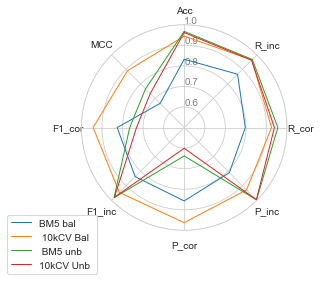

In [86]:
plot_radar(df_CV_10kT,"CV_performance")